In [66]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import tensorflow_hub as hub
from collections import deque
import matplotlib.pyplot as plt
from ultralytics import YOLO

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [67]:
torch.version.cuda()

TypeError: 'NoneType' object is not callable

In [64]:

cv2.destroyAllWindows()

cpu


In [ ]:
# allows to control the randomness
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

dataset = "..\datasets\clips_v1.5"
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 256, 256

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = dataset


# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ["boxing", "handwaving", "running", "walking"]
CLASSES_LIST = ["Jump", "Stand", "Walk", "Turn"]

Visualize

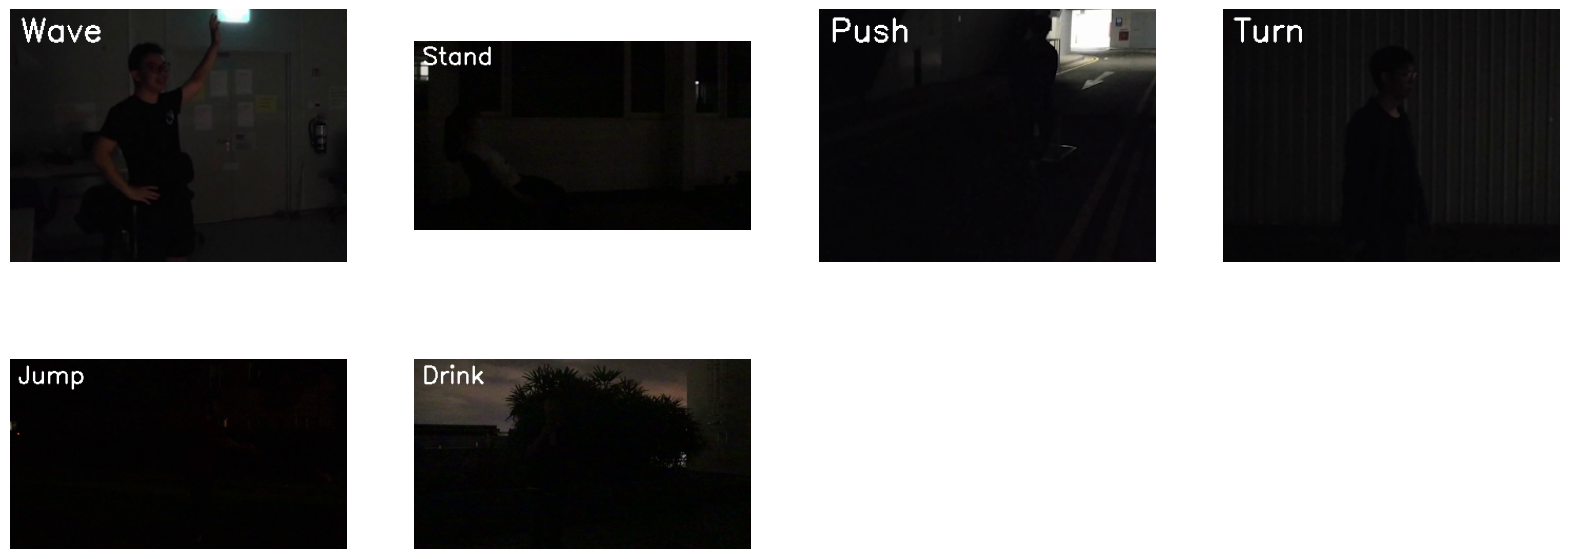

In [8]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(dataset)

# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 6)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{dataset}/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{dataset}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);
    plt.imshow(rgb_frame);plt.axis('off')

# Pre Process

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 256, 256

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = dataset


# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
# CLASSES_LIST = ["boxing", "handwaving", "running", "walking"]
CLASSES_LIST = ["Drink", "Jump", "Run", "Sit", "Stand"]
# CLASSES_LIST = ["Drink", "Jump", "Pour", "Run", "Sit", "Stand", "Walk", "Turn"]

In [56]:
def apply_clahe(frame):
        image = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

        # Adjust the hue, saturation, and value of the image
        # Adjusts the hue by multiplying it by 0.7
        image[:, :, 0] = image[:, :, 0] * 0.7
        # Adjusts the saturation by multiplying it by 1.5
        image[:, :, 1] = image[:, :, 1] * 1.5
        # Adjusts the value by multiplying it by 0.5
        image[:, :, 2] = image[:, :, 2] * 0.5

        # Convert the image back to BGR color space
        image2 = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

        imgGray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
        alpha = 1  # 1.0 - 3.0
        beta = 80  # 0 - 100
        new_image = cv2.convertScaleAbs(imgGray, alpha=alpha, beta=beta)
        gamma = 1.3
        lookUpTable = np.empty((1, 256), np.uint8)
        for i in range(256):
            lookUpTable[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        res = cv2.LUT(new_image, lookUpTable)
        clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8, 8))
        frame = clahe.apply(res)
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        return frame

In [68]:
import cv2
import torch
import numpy as np

# Initialize frames_tensor with the same shape as key_points
def get_frames(video_path):
    frames_tensor = torch.empty(0, 17, 2)
    pose_model  = YOLO('yolov8n-pose.pt')
    video_reader = cv2.VideoCapture(video_path)
    while True:
        sucess, frame = video_reader.read()
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        if not sucess:
            break
        pose = pose_model(frame, show=False, boxes = False, max_det = 1, show_conf=False, show_labels=False, verbose=False)


        for result in pose:
            key_points = result.keypoints.xyn
            if key_points.size(1) == 0:
                continue

            # Concatenate the key_points tensor with frames_tensor
            frames_tensor = torch.cat((frames_tensor, key_points[0].unsqueeze(0)), dim=0)

    skip_window = max(int(frames_tensor.size(0) // SEQUENCE_LENGTH), 1)
    selected_frames_tensor = frames_tensor[::skip_window]

    num_selected_frames = selected_frames_tensor.size(0)
    
    if num_selected_frames < 20:
        num_dummy_frames = SEQUENCE_LENGTH - num_selected_frames
        dummy_frame = torch.zeros(1, 17, 2)
        dummy_frames = dummy_frame.repeat(num_dummy_frames, 1, 1)
        selected_frames_tensor = torch.cat((selected_frames_tensor, dummy_frames), dim=0)


    # Release the VideoCapture object.
    video_reader.release()
    return selected_frames_tensor


In [71]:
cv2.destroyAllWindows()

In [69]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        # frame = apply_clahe(frame)
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        resized_frame = apply_clahe(resized_frame)
        
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [18]:
import os
import torch
import numpy as np

def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A tensor containing the extracted frames of the videos.
        labels:            A tensor containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels, and video file path values.
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:  # Iterate through all the files present in the files list.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = get_frames(video_file_path)

            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Stack the list of tensors to create a single tensor for features
    features = torch.stack(features)

    # Convert labels to a PyTorch tensor
    labels = torch.tensor(labels)

    return features, labels, video_files_paths


## Model

In [19]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

## Training and Prediction

In [ ]:
features, labels, video_files_paths = create_dataset()


In [20]:
one_hot_encoded_labels = to_categorical(labels)
LRCN_model = create_convlstm_model()


Extracting Data of Class: Drink
Extracting Data of Class: Jump
Extracting Data of Class: Run
Extracting Data of Class: Sit
Extracting Data of Class: Stand


: 

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

SyntaxError: incomplete input (2161254594.py, line 1)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

In [ ]:
# Get model predictions for the test dataset
predictions = LRCN_model.predict(features_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot-encoded predictions to class indices

# Calculate the confusion matrix
confusion_mat = confusion_matrix(np.argmax(labels_test, axis=1), predicted_labels)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

Save the Model

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'Models/LRCN_model_Date_Time_{current_date_time_string}_Loss_{model_evaluation_loss}_Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

## Visualizing Metrics

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')